In [ ]:
# dataset - https://www.kaggle.com/datasets/cashutosh/gender-classification-dataset

In [80]:
import torch 
from torch import nn 
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split, Dataset
import torch.nn.functional as F
from torch.optim import Adam, Adagrad, RMSprop 

import numpy as np
import matplotlib.pyplot as plt 
import os 
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay
import time 
from tqdm import tqdm

In [24]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [25]:
device

'cuda'

In [2]:
len(os.listdir("/kaggle/input/gender-classification-dataset/Validation/female"))

5841

In [3]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(degrees=45),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomGrayscale(p=0.2),
    transforms.RandomAffine(degrees=45, translate=(0.1, 0.1), scale=(0.8, 1.2), shear=10),
    transforms.ToTensor()
    
])


val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])


test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(degrees=45),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])


In [4]:
class CustomTransform(Dataset):
    def __init__(self, data, transform_obj=None):
        self.data = data
        self.transform_obj = transform_obj
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        x, y = self.data[idx]

        if self.transform_obj:
            x = self.transform_obj(x)

        return x, y    

In [4]:
# train_dir = '/kaggle/input/gender-classification-dataset/Training'
# train_data = datasets.ImageFolder(train_dir, transform=transform)

# val_dir = '/kaggle/input/gender-classification-dataset/Validation'
# val_data = datasets.ImageFolder(val_dir, transform=val_transform)

# test_dir = '/kaggle/input/gender-classification-dataset/Validation'
# test_data = datasets.ImageFolder(test_dir, transform=test_transform)

In [5]:
dir = "/kaggle/input/gender-classification-dataset/Validation"
data = datasets.ImageFolder(dir, transform = None)

In [9]:
train_ratio = 0.8
train_dataset, val_dataset, test_dataset = random_split(data, [train_ratio, 0.9 - train_ratio, 0.9 - train_ratio])

In [10]:
train_data = CustomTransform(train_dataset, transform_obj = transform)
val_data = CustomTransform(val_dataset, transform_obj = val_transform)
test_data = CustomTransform(test_dataset, transform_obj = test_transform)

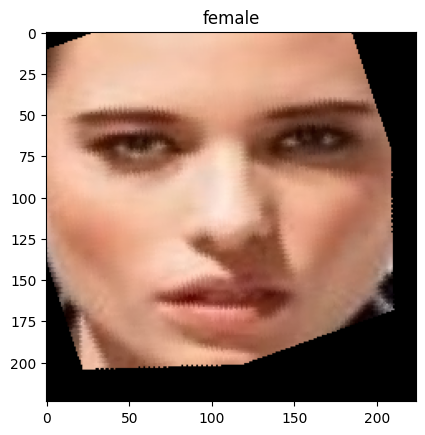

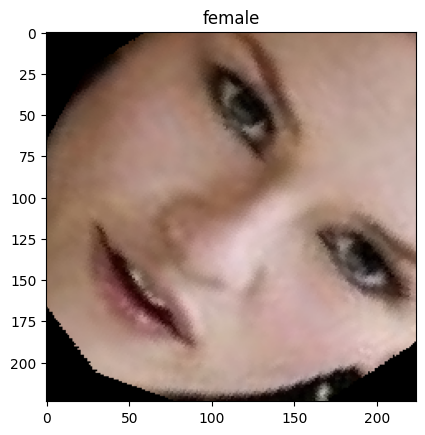

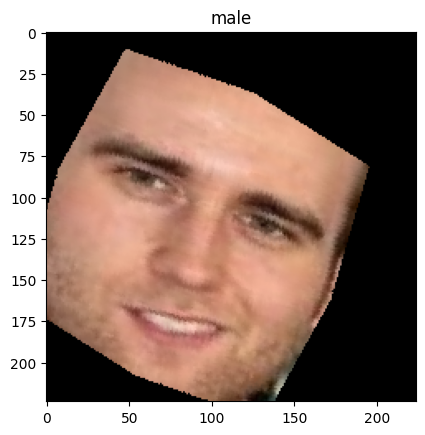

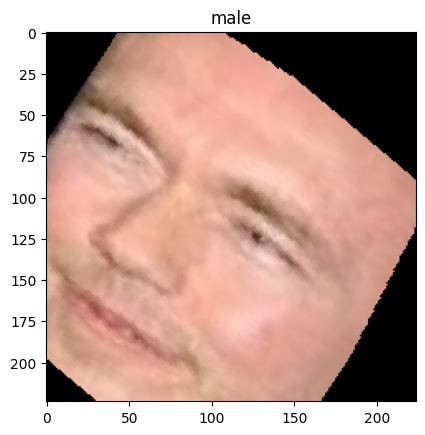

In [11]:
def output(data, limit):
    limit = limit
    count = 0
    
    gender_list = ["female", "male"]  
    
    for x, y in data:
      
        label = gender_list[y]
        feature = x.permute(1, 2, 0)  
        
        # Визуализация
        plt.title(label)
        plt.imshow(feature)
        plt.show()
        
        count += 1
        if count >= limit:
            break



output(train_data, 4)

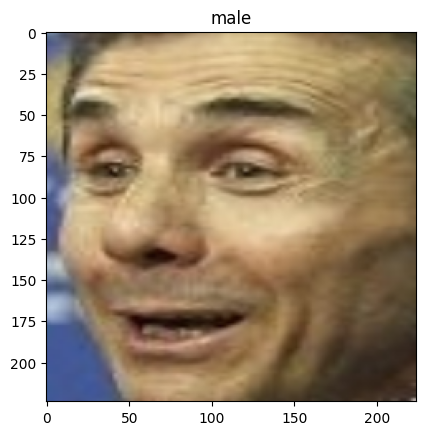

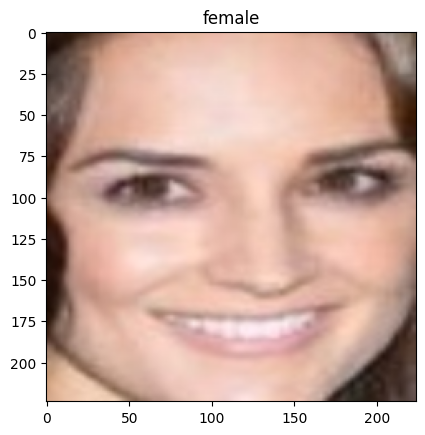

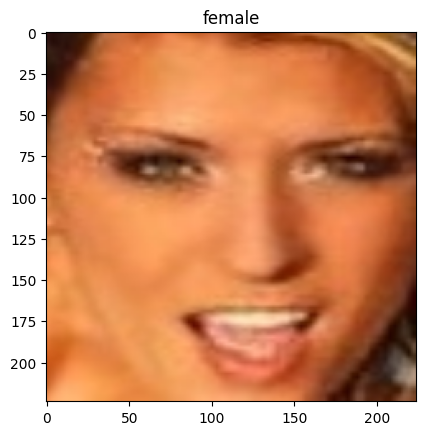

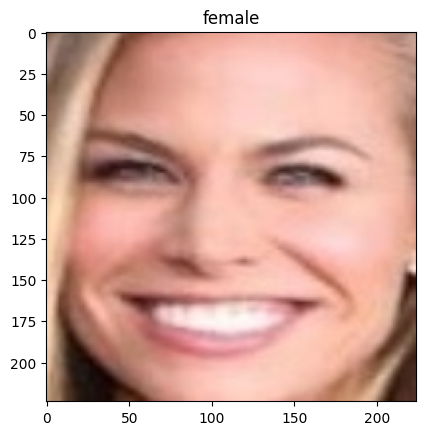

In [12]:
output(val_data, 4)

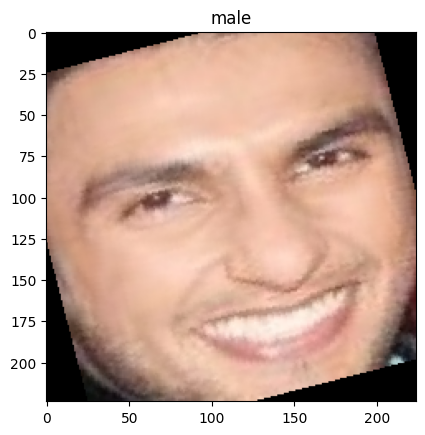

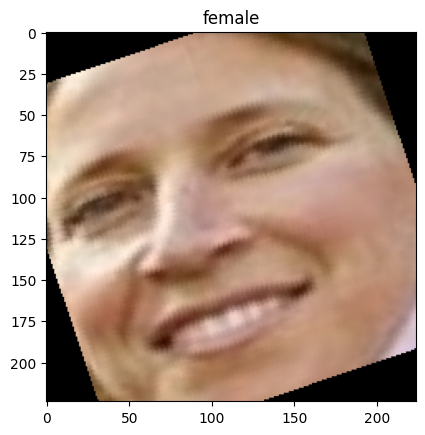

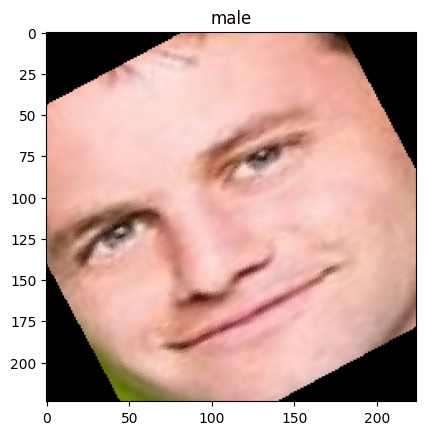

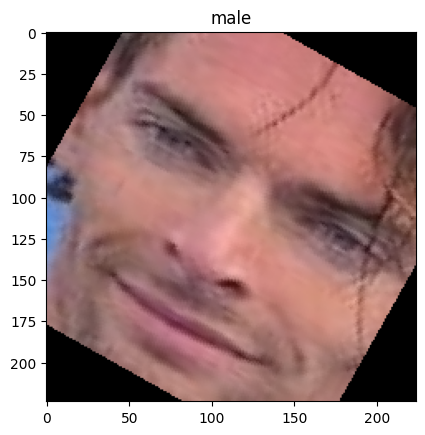

In [13]:
output(test_data, 4)

In [15]:
print(len(train_data), len(val_data), len(test_data))

9320 1165 1164


In [16]:
batch_size = 64

train_dl = DataLoader(train_data, batch_size = batch_size, generator=torch.Generator(device="cpu"))
val_dl = DataLoader(val_data, batch_size = batch_size, generator=torch.Generator(device="cpu"))

In [17]:
class SkipBlock(nn.Module):
    def __init__(self, in_channels, out_channels, pool = False):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size = 3, padding = 1)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size = 3, padding = 1)

        self.add_con = nn.Sequential()

        if in_channels != out_channels:
            self.add_con = nn.Conv2d(in_channels, out_channels, kernel_size = 3, padding = 1)

        if pool == True:
            self.pool = nn.MaxPool2d(kernel_size = 2, stride = 2)
        else:
            self.pool = None

    def forward(self, x):
        out = self.conv1(x)
        add_out = self.add_con(x)

        out = F.relu(out)

        out = self.conv2(out)
        out += add_out

        out = F.relu(out)

        if self.pool:
            out = self.pool(out)

        return out    

In [18]:
tensor = torch.rand(3, 224, 224)

layer0 = nn.Conv2d(in_channels = 3, out_channels = 32, kernel_size=3, padding = 1)
layer1 = SkipBlock(32, 64, pool = True)
layer2 = SkipBlock(64, 128, pool = True)


out = layer0(tensor)
out = F.relu(out)
out = layer1(out)
out = layer2(out)
out.shape

torch.Size([128, 56, 56])

In [47]:
class GenderDetector(nn.Module):
    def __init__(self, outputs = 1):
        super().__init__()
        # 3, 224, 224
        self.conv1 = nn.Conv2d(3, 32, kernel_size = 3, padding = 1)
        self.pool1 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        # 32, 112, 112
        self.block2 = SkipBlock(32, 64, pool = False)
        # 64, 56, 56
        self.block3 = SkipBlock(64, 128, pool = False)
        # 128, 28, 28

        # self.block4 = SkipConBlock(128, 256, bnorm = False, pool = False)
        
        self.conv4 = nn.Conv2d(128, 256, kernel_size = 3, padding = 1)
        self.pool4 = nn.MaxPool2d(kernel_size = 2, stride = 2)

        self.conv4_1 = nn.Conv2d(256, 512, kernel_size = 3, padding = 1)
        self.pool4_1 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        
        # 256, 7, 7
        self.block5 = SkipBlock(512, 512, pool = False)
        # 512, 3, 3
        self.conv5 = nn.Conv2d(512, 1024, kernel_size = 3, padding = 1)
        self.pool5 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        # 512, 1, 1

        self.flatten = nn.Flatten()

        self.linear1 = nn.Linear(1024, 512)
        self.bnorm1_1 = nn.BatchNorm1d(512)
        self.dropout = nn.Dropout(0.3)

        self.linear2 = nn.Linear(512, 32)
        self.linear3 = nn.Linear(32, outputs)

    def forward(self, x):
        
        out = self.conv1(x)
        out = F.relu(out)
        out = self.pool1(out)
        out = self.pool1(out)

        out = self.block2(out)
        ut = F.relu(out)
        out = self.pool1(out)
        
        out = self.block3(out)
        out = F.relu(out)
        out = self.pool1(out)

        out = self.conv4(out)
        out = F.relu(out)
        out = self.pool4(out)

        out = self.conv4_1(out)
        out = F.relu(out)
        out = self.pool4_1(out)

        out = self.block5(out)
        out = F.relu(out)
        # out = self.pool1(out)

        out = self.conv5(out)
        out = self.pool5(out)
        out = F.relu(out)

        out = self.flatten(out)

        out = self.linear1(out)
        out = F.relu(out)
        out = self.bnorm1_1(out)
        out = self.dropout(out)

        out = self.linear2(out)
        out = F.relu(out)
        out = self.linear3(out)
        res = F.sigmoid(out)

        return res 

    def predict(self, x):
        data = torch.tensor(x, dtype=torch.float32)
        self.eval()

        with torch.no_grad():
            res = self.forward(data)

        return res 

In [51]:
model = GenderDetector()
model.to(device)

GenderDetector(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (block2): SkipBlock(
    (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (add_con): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (block3): SkipBlock(
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (add_con): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4_1): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool4_1): MaxPool2d(kernel_size=2, st

In [20]:
!pip install -q torchsummary

In [28]:
from torchsummary import summary 

summary(model, input_size = (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]             896
         MaxPool2d-2         [-1, 32, 112, 112]               0
         MaxPool2d-3           [-1, 32, 56, 56]               0
            Conv2d-4           [-1, 64, 56, 56]          18,496
            Conv2d-5           [-1, 64, 56, 56]          18,496
            Conv2d-6           [-1, 64, 56, 56]          36,928
         SkipBlock-7           [-1, 64, 56, 56]               0
         MaxPool2d-8           [-1, 64, 28, 28]               0
            Conv2d-9          [-1, 128, 28, 28]          73,856
           Conv2d-10          [-1, 128, 28, 28]          73,856
           Conv2d-11          [-1, 128, 28, 28]         147,584
        SkipBlock-12          [-1, 128, 28, 28]               0
        MaxPool2d-13          [-1, 128, 14, 14]               0
           Conv2d-14          [-1, 256,

In [29]:
def train(model, optimizer, loss_fn, train_dl, val_dl,
          metrics=None, metrics_name=None, epochs=20, device='cpu', task='binary'):
    
    print('train() called: model=%s, opt=%s(lr=%f), epochs=%d, device=%s\n' % \
          (type(model).__name__, type(optimizer).__name__,
           optimizer.param_groups[0]['lr'], epochs, device))

    # Use default metric if none provided
    metrics = metrics if metrics else [accuracy_score]
    metrics_name = metrics_name if metrics_name else [metric.__name__ for metric in metrics]

    history = {}
    history['loss'] = []
    history['val_loss'] = []
    for name in metrics_name:
        history[name] = []
        history[f'val_{name}'] = []

    start_time_train = time.time()

    # Enable anomaly detection to catch the error
    torch.autograd.set_detect_anomaly(True)

    for epoch in range(epochs):
        # --- TRAIN AND EVALUATE ON TRAINING SET -----------------------------
        start_time_epoch = time.time()

        model.train()
        history_train = {name: 0 for name in ['loss'] + metrics_name}

        for batch in tqdm(train_dl):
            x = batch[0].to(device)
            y = batch[1].to(device)
            
            y_pred = model(x)
            loss = loss_fn(y_pred.squeeze(), y.float())  # squeeze in case of single output neuron

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            y_pred = y_pred.detach().cpu().numpy()
            y = y.detach().cpu().numpy()

            history_train['loss'] += loss.item() * x.size(0)
            for name, func in zip(metrics_name, metrics):
                try:
                    history_train[name] += func(y, y_pred.round()) * x.size(0)  # round for binary classification
                except:
                    history_train[name] += func(y, y_pred) * x.size(0)

        for name in history_train:
            history_train[name] /= len(train_dl.dataset)

        # --- EVALUATE ON VALIDATION SET -------------------------------------
        model.eval()
        history_val = {'val_' + name: 0 for name in metrics_name + ['loss']}

        with torch.no_grad():
            for batch in tqdm(val_dl):
                x = batch[0].to(device)
                y = batch[1].to(device)

                y_pred = model(x)
                loss = loss_fn(y_pred.squeeze(), y.float())  # squeeze in case of single output neuron

                y_pred = y_pred.cpu().numpy()
                y = y.cpu().numpy()

                history_val['val_loss'] += loss.item() * x.size(0)
                for name, func in zip(metrics_name, metrics):
                    try:
                        history_val['val_' + name] += func(y, y_pred.round()) * x.size(0)  # round for binary classification
                    except:
                        history_val['val_' + name] += func(y, y_pred) * x.size(0)

        for name in history_val:
            history_val[name] /= len(val_dl.dataset)

        # PRINTING RESULTS

        end_time_epoch = time.time()

        for name in history_train:
            history[name].append(history_train[name])
            history['val_' + name].append(history_val['val_' + name])

        total_time_epoch = end_time_epoch - start_time_epoch

        print(f'Epoch {epoch+1:4d} {total_time_epoch:4.0f}sec', end='\t')
        for name in history_train:
            print(f'{name}: {history[name][-1]:10.3g}', end='\t')
            print(f"val_{name}: {history['val_'+name][-1]:10.3g}", end='\t')
        print()

    # END OF TRAINING LOOP

    end_time_train = time.time()
    total_time_train = end_time_train - start_time_train
    print()
    print('Time total:     %5.2f sec' % (total_time_train))

    return history

In [52]:
loss = nn.BCELoss()

In [53]:
# optmimizer = AdamW(model.parameters(), lr = 1e-3, weight_decay = 1e-5)
optmimizer = Adam(model.parameters(), lr = 1e-3)
# optmimizer = RMSprop(model.parameters(), lr = 1e-3, momentum=0.9)

In [54]:
history = train(model, optmimizer, loss, train_dl, val_dl, metrics=[accuracy_score], device = device, task = "binary", epochs = 20)

train() called: model=GenderDetector, opt=Adam(lr=0.001000), epochs=20, device=cuda



100%|██████████| 19/19 [00:03<00:00,  5.31it/s]


Epoch    1   46sec	loss:      0.666	val_loss:       1.03	accuracy_score:      0.603	val_accuracy_score:      0.509	


100%|██████████| 19/19 [00:03<00:00,  5.10it/s]


Epoch    2   46sec	loss:       0.63	val_loss:      0.838	accuracy_score:      0.653	val_accuracy_score:       0.48	


100%|██████████| 19/19 [00:03<00:00,  5.32it/s]


Epoch    3   46sec	loss:      0.611	val_loss:       1.26	accuracy_score:      0.673	val_accuracy_score:       0.48	


100%|██████████| 19/19 [00:03<00:00,  5.10it/s]


Epoch    4   47sec	loss:      0.573	val_loss:       1.65	accuracy_score:       0.71	val_accuracy_score:       0.53	


100%|██████████| 19/19 [00:03<00:00,  5.56it/s]


Epoch    5   46sec	loss:      0.563	val_loss:      0.946	accuracy_score:      0.719	val_accuracy_score:      0.492	


100%|██████████| 19/19 [00:03<00:00,  5.23it/s]


Epoch    6   47sec	loss:      0.545	val_loss:      0.664	accuracy_score:      0.733	val_accuracy_score:      0.657	


100%|██████████| 19/19 [00:03<00:00,  5.49it/s]


Epoch    7   46sec	loss:      0.528	val_loss:      0.536	accuracy_score:      0.741	val_accuracy_score:      0.717	


100%|██████████| 19/19 [00:03<00:00,  5.47it/s]


Epoch    8   46sec	loss:      0.498	val_loss:      0.886	accuracy_score:      0.764	val_accuracy_score:      0.634	


100%|██████████| 19/19 [00:03<00:00,  4.96it/s]


Epoch    9   47sec	loss:      0.457	val_loss:      0.394	accuracy_score:      0.789	val_accuracy_score:      0.827	


100%|██████████| 19/19 [00:03<00:00,  5.18it/s]


Epoch   10   46sec	loss:      0.455	val_loss:      0.434	accuracy_score:      0.796	val_accuracy_score:      0.804	


100%|██████████| 19/19 [00:03<00:00,  5.35it/s]


Epoch   11   46sec	loss:      0.398	val_loss:      0.289	accuracy_score:      0.825	val_accuracy_score:       0.88	


100%|██████████| 19/19 [00:07<00:00,  2.54it/s]


Epoch   12   51sec	loss:      0.377	val_loss:      0.251	accuracy_score:      0.837	val_accuracy_score:      0.896	


100%|██████████| 19/19 [00:09<00:00,  2.06it/s]


Epoch   13   72sec	loss:      0.352	val_loss:      0.259	accuracy_score:      0.846	val_accuracy_score:      0.907	


100%|██████████| 19/19 [00:09<00:00,  2.00it/s]


Epoch   14   80sec	loss:       0.33	val_loss:      0.302	accuracy_score:      0.859	val_accuracy_score:      0.868	


100%|██████████| 19/19 [00:03<00:00,  5.28it/s]


Epoch   15   61sec	loss:      0.319	val_loss:      0.269	accuracy_score:      0.869	val_accuracy_score:      0.896	


100%|██████████| 19/19 [00:03<00:00,  5.09it/s]


Epoch   16   47sec	loss:      0.303	val_loss:      0.235	accuracy_score:      0.874	val_accuracy_score:      0.914	


100%|██████████| 19/19 [00:03<00:00,  5.35it/s]


Epoch   17   46sec	loss:      0.294	val_loss:      0.457	accuracy_score:      0.875	val_accuracy_score:      0.906	


100%|██████████| 19/19 [00:03<00:00,  5.09it/s]


Epoch   18   47sec	loss:      0.276	val_loss:      0.253	accuracy_score:      0.889	val_accuracy_score:      0.898	


100%|██████████| 19/19 [00:03<00:00,  5.56it/s]


Epoch   19   47sec	loss:      0.268	val_loss:       0.24	accuracy_score:      0.891	val_accuracy_score:      0.906	


100%|██████████| 19/19 [00:03<00:00,  5.29it/s]

Epoch   20   46sec	loss:      0.266	val_loss:      0.236	accuracy_score:      0.888	val_accuracy_score:      0.904	

Time total:     1006.23 sec


In [97]:
def output_training(name, history):
    plt.plot(history[name], label = "train")
    plt.plot(history[f"val_{name}" ], label = "validation")
    plt.legend()
    plt.xlabel("Epoch")
    plt.ylabel("Value")
    plt.show()

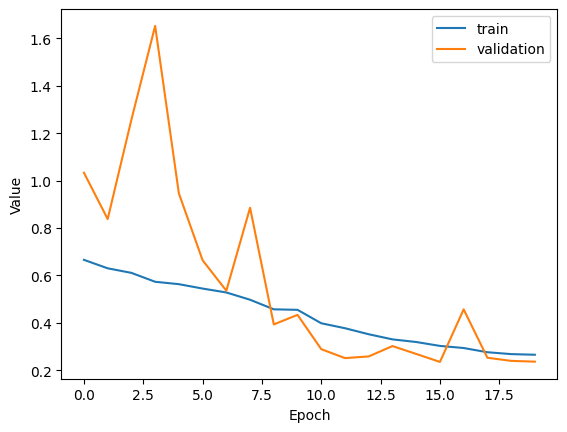

In [98]:
output_training("loss", history)

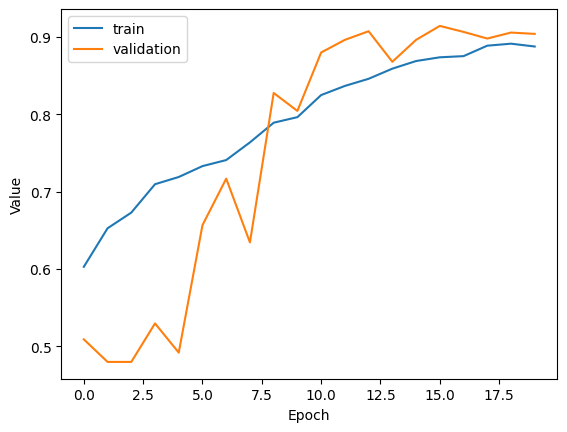

In [99]:
output_training("accuracy_score", history)

In [37]:
test_tensor.shape

torch.Size([3, 224, 224])

In [39]:
x, y = train_data[0]
x.shape

torch.Size([3, 224, 224])

In [56]:
test_tensor = torch.rand(1, 3, 224, 224).to(device)
out = model.predict(test_tensor)
out.item()

/tmp/ipykernel_30/2166855884.py:83: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(x, dtype=torch.float32)


0.9978294968605042

In [58]:
batch_size = 64

test_dl = DataLoader(test_data, batch_size = batch_size, generator=torch.Generator(device = "cpu"))

In [60]:
for x, y in test_dl:
    print(x.device)
    break

cpu


In [78]:
def evaluate(model, data):
    loss = nn.BCELoss()
    
    t_model = model.to("cpu")
    t_model.eval()
    
    total_loss = 0
    total_acc = 0

    with torch.no_grad():
    
        for x, y in tqdm(data):
            
            out = t_model(x)
            fin_out = (out > 0.5).float()
        
            t_acc = accuracy_score(fin_out.numpy(), y.numpy())
            total_acc += t_acc
    
            y = y.unsqueeze(1).float()
            t_loss = loss(out, y)
            total_loss += t_loss
       
    acc = total_acc / len(test_dl)
    loss = total_loss / len(test_dl)
    
    res = f"[[Accuracy: {acc}][Loss: {loss}]]"
    print(res)

    
evaluate(model, test_dl)  

100%|██████████| 19/19 [00:21<00:00,  1.12s/it]

[[Accuracy: 0.9136513157894737][Loss: 0.24259431660175323]]


In [90]:
t_model = model.to("cpu")
t_model.eval()

y_true = []
y_pred = []

with torch.no_grad():

    for x, y in tqdm(test_dl):
        x = x.to("cpu")
        y = y.to("cpu")
        
        y = y.numpy()
        y_pred.append(y)

        preds = t_model(x)
        preds = (preds > 0.5).float().numpy()
        
        y_pred.append(preds)

# y_pred = y_pred.numpy()
# y_true = y_true.numpy()


# ConfusionMatrixDisplay.from_predictions(y_true, y_pred, display_labels = ["female", "male"])
# plt.title("Gender classification")
# plt.plot()

100%|██████████| 19/19 [00:25<00:00,  1.32s/it]


In [91]:
y_true

[]

100%|██████████| 19/19 [00:21<00:00,  1.13s/it]


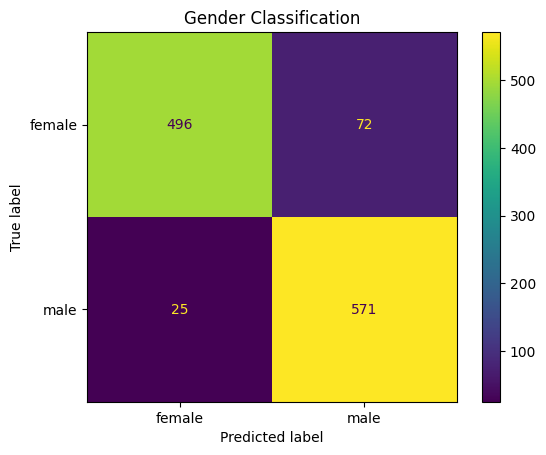

In [92]:
t_model = model.to("cpu")
t_model.eval()

y_true = []
y_pred = []

with torch.no_grad():
    for x, y in tqdm(test_dl):
        x = x.to("cpu")
        y = y.to("cpu").numpy()  
        
        preds = t_model(x)  
        preds = (preds > 0.5).float().numpy()  
        
        y_true.extend(y)  
        y_pred.extend(preds)  

y_true = np.array(y_true).flatten()
y_pred = np.array(y_pred).flatten()

ConfusionMatrixDisplay.from_predictions(y_true, y_pred, display_labels=["female", "male"])
plt.title("Gender Classification")
plt.show()

In [100]:
torch.save(model.state_dict(), "gender_model.pt")

In [104]:
t_model = GenderDetector()
t_model.load_state_dict(torch.load("/kaggle/working/gender_model.pt"))

/tmp/ipykernel_30/395904980.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  t_model.load_state_dict(torch.load("/kaggle/working/gender_model.pt"))


<All keys matched successfully>

In [105]:
evaluate(t_model, test_dl)

100%|██████████| 19/19 [00:21<00:00,  1.15s/it]

[[Accuracy: 0.8941885964912281][Loss: 0.23727431893348694]]
